In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

BIG_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 20

matplotlib.rc('axes', titlesize=BIGGEST_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=BIGGEST_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

The following results correponds to SPDE where we remove $\hat{z} \times \tilde{\mathbf{u}}$ , $\nabla (\xi \cdot R)$ and replace $\nabla \cdot (\tilde{\mathbf{u}} \theta)$ with $\tilde{\mathbf{u}} \cdot \nabla \theta$ from SALT parameterised atmosphere .
We use CN scheme for time-discretisation of SPDE.

In [3]:
data_t1 = np.load('../../../deterministic/224x32/data_from_deterministic_run/coarse_grained_vel_temp_vort_data_t=27_to_t=36_grid_32_c=1by32_decor_t_80min.npz') # coarse grained high. res. sol.
data_t2 = np.load('../../../deterministic/224x32/data_from_deterministic_run/coarse_grained_vel_temp_vort_data_t=36_to_t=45_grid_32_c=1by32_decor_t_80min.npz') # coarse grained high. res. sol. 
data_d = np.load('../../../deterministic/224x32/data_from_deterministic_run/coarse_grid_sim_vel_temp_vort_data_t=27_to_t=45_coarse_grained_ic.npz') # deterministic solution on coarse grid
data_adap = np.load('../../../deterministic/224x32/data_from_deterministic_run/adaptive_sol_mesh_32_sim_vel_temp_data_t=27_to_t=45_coarse_grained_ic.npz') # adapted ref. solution. we remove \nabla (\xi. R) and replace \nabla. (u_pert \theta) with u_pert . \nabla \theta

In [4]:
vel_data_t1 = data_t1['vel_data_truth']
temp_data_t1 = data_t1['temp_data_truth']
vort_data_t1 = data_t1['vort_data_truth']
vel_data_t2 = data_t2['vel_data_truth']
temp_data_t2 = data_t2['temp_data_truth']
vort_data_t2 = data_t2['vort_data_truth']
vel_data_d = data_d['vel_data']
temp_data_d = data_d['temp_data']
vort_data_d = data_d['vort_data']
vel_data_adap = data_adap['vel_data']
temp_data_adap = data_adap['temp_data']

In [5]:
gridpoints = data_t1['gridpoints']

In [6]:
print(gridpoints)

[[1.75 0.25]
 [3.5  0.25]
 [5.25 0.25]
 [1.75 0.5 ]
 [3.5  0.5 ]
 [5.25 0.5 ]
 [1.75 0.75]
 [3.5  0.75]
 [5.25 0.75]]


In [7]:
vel_data_t = np.concatenate((vel_data_t1, vel_data_t2),axis=0)
vel_data_t.shape

(19, 9, 2)

In [8]:
temp_data_t = np.concatenate((temp_data_t1, temp_data_t2), axis=0)
temp_data_t.shape

(19, 9)

In [9]:
vort_data_t = np.concatenate((vort_data_t1, vort_data_t2), axis=0)
vort_data_t.shape

(19, 9)

In [10]:
n_tsteps = 19 
n_obs_points = gridpoints.shape[0]
n_stoch_sim_1 = 50

In [11]:
# calculating 1-std data for x-vel from all stochastic simulations at all points
vel_x_std_data_plus = np.zeros((n_tsteps,n_obs_points))
vel_x_std_data_minus = np.zeros((n_tsteps,n_obs_points))
vel_x_mean_mat = np.zeros((n_tsteps,n_obs_points))

vel_y_std_data_plus = np.zeros((n_tsteps,n_obs_points))
vel_y_std_data_minus = np.zeros((n_tsteps,n_obs_points))
vel_y_mean_mat = np.zeros((n_tsteps,n_obs_points))
for l in range(n_obs_points):
    vel_x_data_stoch_mat = np.zeros((n_tsteps,n_stoch_sim_1)) # at a location
    vel_y_data_stoch_mat = np.zeros((n_tsteps,n_stoch_sim_1))
    for k in range(n_stoch_sim_1):
        data_stoch = np.load('../data_from_stochastic_run/vel_temp_vort_data_particle_'+str(k+1)+'_var_90_grid_32_t27_onwards_decor_t_32min_upd_noise.npz')
        vel_data_stoch = data_stoch['vel_data_sto']  
        vel_x_data_stoch_mat[:,k] = vel_data_stoch[:n_tsteps,l, 0]
        vel_y_data_stoch_mat[:,k] = vel_data_stoch[:n_tsteps,l, 1]

    vel_x_data_mean = np.mean(vel_x_data_stoch_mat, axis = 1, keepdims=True)
    vel_x_data_std = np.std(vel_x_data_stoch_mat, axis = 1, keepdims=True)

    vel_y_data_mean = np.mean(vel_y_data_stoch_mat, axis = 1, keepdims=True)
    vel_y_data_std = np.std(vel_y_data_stoch_mat, axis = 1, keepdims=True)

    vel_x_std_plus = vel_x_data_mean + vel_x_data_std
    vel_x_std_minus = vel_x_data_mean - vel_x_data_std

    vel_y_std_plus = vel_y_data_mean + vel_y_data_std
    vel_y_std_minus = vel_y_data_mean - vel_y_data_std

    vel_x_std_data_plus[:,l] = vel_x_std_plus[:,0]
    vel_x_std_data_minus[:,l] = vel_x_std_minus[:,0]
    vel_x_mean_mat[:,l] = vel_x_data_mean[:,0]

    vel_y_std_data_plus[:,l] = vel_y_std_plus[:,0]
    vel_y_std_data_minus[:,l] = vel_y_std_minus[:,0]
    vel_y_mean_mat[:,l] = vel_y_data_mean[:,0]

In [12]:
vel_x_std_plus_50_p = vel_x_std_data_plus 
vel_x_std_minus_50_p = vel_x_std_data_minus
vel_x_mean_50_p = vel_x_mean_mat

vel_y_std_plus_50_p = vel_y_std_data_plus 
vel_y_std_minus_50_p = vel_y_std_data_minus
vel_y_mean_50_p = vel_y_mean_mat

[Text(0, 0.5, '${ \\bf zonal \\ velocity }$'),
 Text(0, 0.5, '${ \\bf zonal \\ velocity }$'),
 Text(0, 0.5, '${ \\bf zonal \\ velocity }$')]

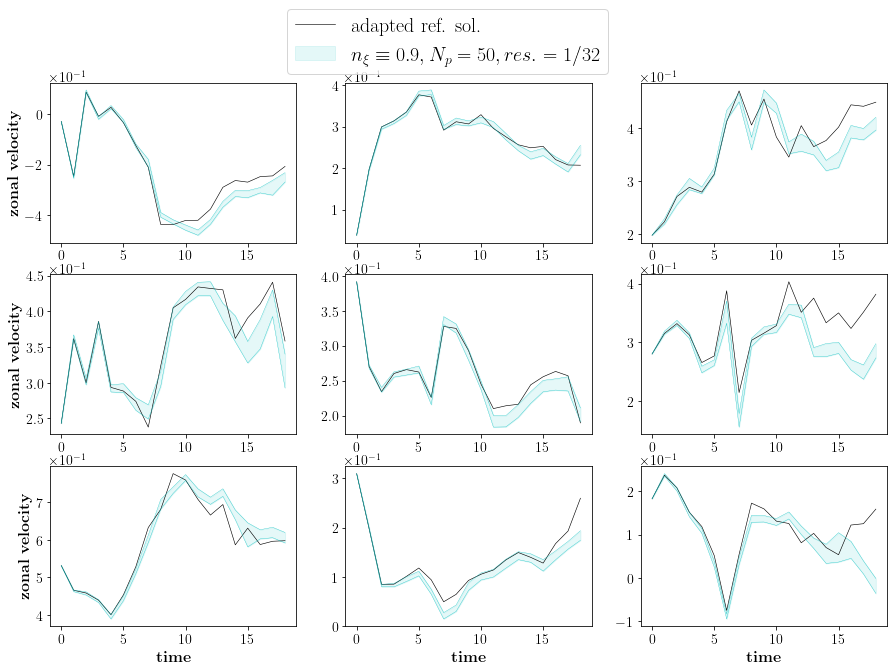

In [13]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(3,3, figsize=(15, 10))
n = 0
spread_col_100p = "blue"
spread_col_50p = "c"
t_col = "red"
for i in [2,1,0]:
    for j in [0,1,2]:
        # ax[i,j].plot(vel_data_d[sp:n_tsteps,n,0], label = 'deterministic', linewidth=0.6, color="blue")
        ax[i,j].plot(vel_data_adap[sp:n_tsteps,n,0], label = 'adapted ref. sol.', linewidth=0.6, color="black")
        # ax[i,j].plot(vel_data_t[sp:n_tsteps,n,0], label = 'c. truth', color=t_col, linewidth=0.6)
        ax[i,j].plot(vel_x_std_plus_50_p[sp:,n], color="c", linewidth=0.3)
        ax[i,j].plot(vel_x_std_minus_50_p[sp:,n], color="c", linewidth=0.3)
        ax[i,j].fill_between(np.arange(n_tsteps - sp),vel_x_std_plus_50_p[sp:,n],vel_x_std_minus_50_p[sp:,n], alpha=.1, color="c", label=r'$n_{\xi}\equiv 0.9, N_p = 50, res. = 1/32$' )
        ax[i,j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
        n += 1
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
# set labels
plt.setp(ax[-1, :], xlabel=r'${ \bf time }$')
plt.setp(ax[:, 0], ylabel=r'${ \bf zonal \ velocity }$')

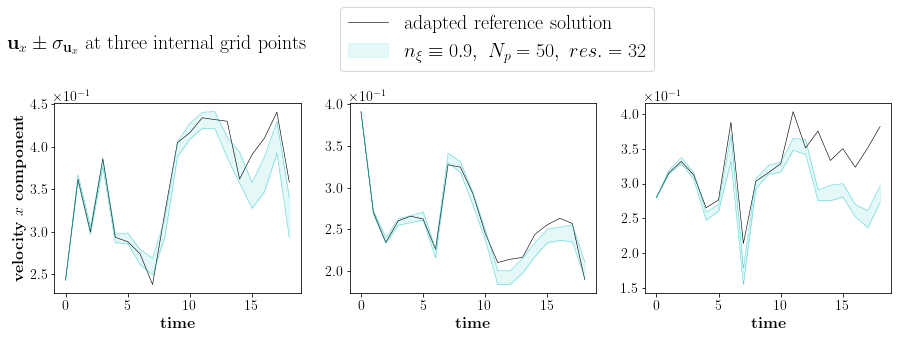

In [16]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(1,3, figsize=(15, 3.5))
n = 3 # we are plotting from the 4th gridpoint onwards
spread_col_100p = "blue"
spread_col_50p = "c"
lime_c = '#00FF00' # this is neon green !
t_col = "red"
for j in [0,1,2]:
    # ax[j].plot(vel_data_d[sp:n_tsteps,n,0], label = 'deterministic', linewidth=0.6, color="blue")
    ax[j].plot(vel_data_adap[sp:n_tsteps,n,0], label = r'adapted reference solution', linewidth=0.6, color="black")
    # ax[j].plot(vel_data_t[sp:n_tsteps,n,0], label = 'c. truth', color=t_col, linewidth=0.6)
    ax[j].plot(vel_x_std_plus_50_p[sp:,n], color=spread_col_50p, linewidth=0.3)
    ax[j].plot(vel_x_std_minus_50_p[sp:,n], color=spread_col_50p, linewidth=0.3)
    ax[j].fill_between(np.arange(n_tsteps - sp),vel_x_std_plus_50_p[sp:,n],vel_x_std_minus_50_p[sp:,n], alpha=.1, color=spread_col_50p, label=r'$n_{\xi}\equiv 0.9, \ N_p = 50, \ res. = 32$' )
    ax[j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
    n += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.38, 1.3), ncol=1) # positions the legend above the top of the plot without overlapping. 
# The 0.5 places it in the center, while 1.1 moves it slightly above the top of the figure.
# set labels
fig.suptitle(r'$\mathbf{u}_x \pm \sigma_{\mathbf{u}_x}$ at three internal grid points', x = 0.22, y = 1.15)
plt.setp(ax[:], xlabel=r'\bf {time}')
plt.setp(ax[0], ylabel=r'\bf {velocity} $x$ \bf{component}')
plt.savefig('../plots/gaussian_noise/ensem_x_vel_mesh_32_90_var_gaussian.pdf',bbox_inches='tight' )

[Text(0, 0.5, '${ \\bf meridional \\ velocity }$'),
 Text(0, 0.5, '${ \\bf meridional \\ velocity }$'),
 Text(0, 0.5, '${ \\bf meridional \\ velocity }$')]

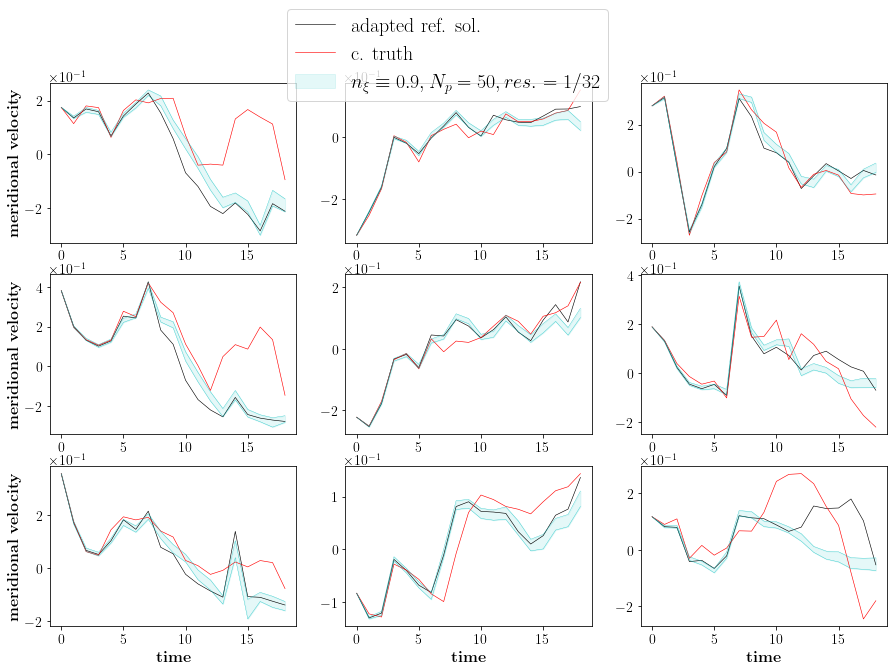

In [18]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(3,3, figsize=(15, 10))
n = 0
spread_col_100p = "blue"
spread_col_50p = "c"
t_col = "red"
for i in [2,1,0]:
    for j in [0,1,2]:
        # ax[i,j].plot(vel_data_d[sp:n_tsteps,n,1], label = 'deterministic', linewidth=0.6, color="blue")
        ax[i,j].plot(vel_data_adap[sp:n_tsteps,n,1], label = 'adapted ref. sol.', linewidth=0.6, color="black")
        ax[i,j].plot(vel_data_t[sp:n_tsteps,n,1], label = 'c. truth', color=t_col, linewidth=0.6)
        ax[i,j].plot(vel_y_std_plus_50_p[sp:,n], color="c", linewidth=0.3)
        ax[i,j].plot(vel_y_std_minus_50_p[sp:,n], color="c", linewidth=0.3)
        ax[i,j].fill_between(np.arange(n_tsteps - sp),vel_y_std_plus_50_p[sp:,n],vel_y_std_minus_50_p[sp:,n], alpha=.1, color="c", label=r'$n_{\xi}\equiv 0.9, N_p = 50, res. = 1/32$' )
        ax[i,j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
        n += 1
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
# set labels
plt.setp(ax[-1, :], xlabel=r'${ \bf time }$')
plt.setp(ax[:, 0], ylabel=r'${ \bf meridional \ velocity }$')

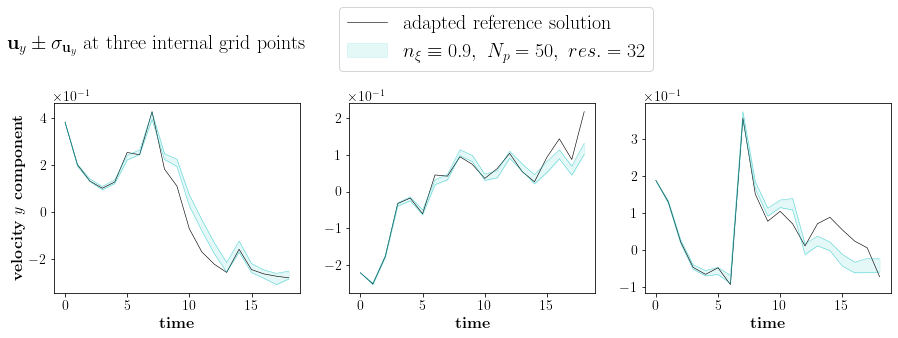

In [25]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(1,3, figsize=(15, 3.5))
n = 3 # we are plotting from the 4th gridpoint onwards
spread_col_100p = "blue"
spread_col_50p = "c"
t_col = "red"
for j in [0,1,2]:
    # ax[j].plot(vel_data_d[sp:n_tsteps,n,1], label = 'deterministic', linewidth=0.6, color="blue")
    ax[j].plot(vel_data_adap[sp:n_tsteps,n,1], label = r'adapted reference solution', linewidth=0.6, color="black")
    # ax[j].plot(vel_data_t[sp:n_tsteps,n,1], label = 'c. truth', color=t_col, linewidth=0.6)
    ax[j].plot(vel_y_std_plus_50_p[sp:,n], color="c", linewidth=0.3)
    ax[j].plot(vel_y_std_minus_50_p[sp:,n], color="c", linewidth=0.3)
    ax[j].fill_between(np.arange(n_tsteps - sp),vel_y_std_plus_50_p[sp:,n],vel_y_std_minus_50_p[sp:,n], alpha=.1, color="c", label=r'$n_{\xi}\equiv 0.9, \ N_p = 50, \ res. = 32$' )
    ax[j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
    n += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.38, 1.3), ncol=1) # positions the legend above the top of the plot without overlapping. 
# The 0.5 places it in the center, while 1.1 moves it slightly above the top of the figure.
# set labels
fig.suptitle(r'$\mathbf{u}_y \pm \sigma_{\mathbf{u}_y}$ at three internal grid points', x = 0.22, y = 1.15)
plt.setp(ax[:], xlabel=r'\bf {time}')
plt.setp(ax[0], ylabel=r'\bf {velocity} $y$ \bf{component}')
plt.savefig('../plots/gaussian_noise/ensem_y_vel_mesh_32_90_var_gaussian.pdf',bbox_inches='tight' )

In [20]:
# calculating 1-std data for temperature from all stochastic simulations at all points
temp_std_data_plus = np.zeros((n_tsteps,n_obs_points))
temp_std_data_minus = np.zeros((n_tsteps,n_obs_points))
temp_data_mean_mat = np.zeros((n_tsteps,n_obs_points))
for l in range(n_obs_points):
    temp_data_stoch_mat = np.zeros((n_tsteps,n_stoch_sim_1)) # at a location
    for k in range(n_stoch_sim_1):
        data_stoch = np.load('../data_from_stochastic_run/vel_temp_vort_data_particle_'+str(k+1)+'_var_90_grid_32_t27_onwards_decor_t_32min_upd_noise.npz')
        temp_data_stoch = data_stoch['temp_data_sto'] 
        temp_data_stoch_mat[:,k] = temp_data_stoch[:n_tsteps,l]
    temp_data_mean = np.mean(temp_data_stoch_mat, axis = 1, keepdims=True)
    temp_data_std = np.std(temp_data_stoch_mat, axis = 1, keepdims=True)
    temp_std_plus = temp_data_mean + temp_data_std
    temp_std_minus = temp_data_mean - temp_data_std
    temp_std_data_plus[:,l] = temp_std_plus[:,0]
    temp_std_data_minus[:,l] = temp_std_minus[:,0]
    temp_data_mean_mat[:,l] = temp_data_mean[:,0]

In [21]:
temp_std_plus_50p = temp_std_data_plus
temp_std_minus_50p = temp_std_data_minus
temp_mean_50p = temp_data_mean_mat

[Text(0, 0.5, '${ \\bf temperature }$'),
 Text(0, 0.5, '${ \\bf temperature }$'),
 Text(0, 0.5, '${ \\bf temperature }$')]

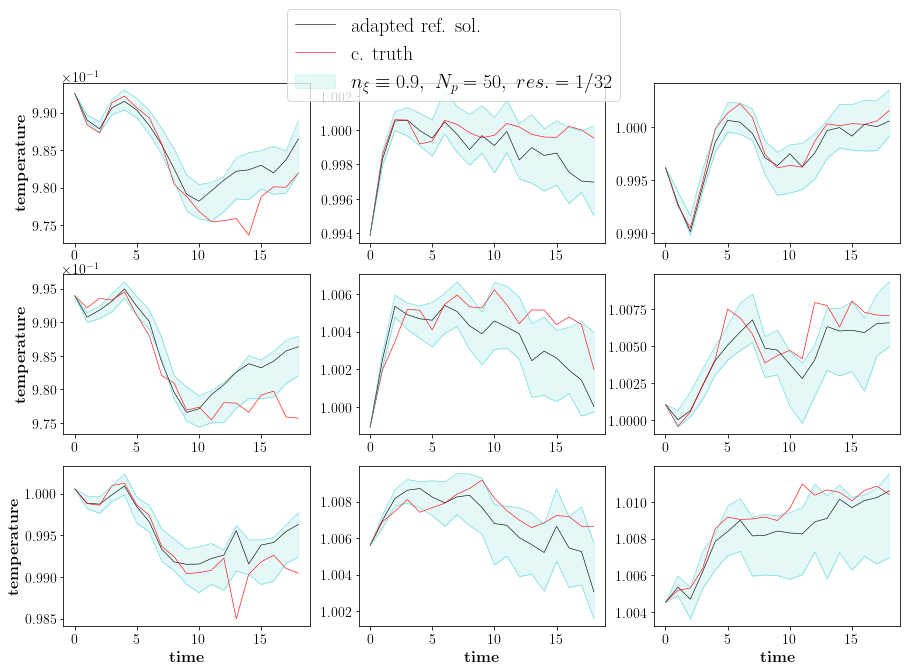

In [22]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(3,3, figsize=(15,10))
n = 0
spread_col_100p = "blue"
spread_col_50p = "c"
t_col = "red"
for i in [2,1,0]:
    for j in [0,1,2]:
        # ax[i,j].plot(temp_data_d[sp:n_tsteps,n], label = 'deterministic', linewidth=0.6, color="blue")
        ax[i,j].plot(temp_data_adap[sp:n_tsteps,n], label = 'adapted ref. sol.', linewidth=0.6, color="black")
        ax[i,j].plot(temp_data_t[sp:n_tsteps,n], label = 'c. truth', color=t_col, linewidth=0.6)
        ax[i,j].plot(temp_std_plus_50p[sp:,n], color=spread_col_50p, linewidth=0.3)
        ax[i,j].plot(temp_std_minus_50p[sp:,n], color=spread_col_50p, linewidth=0.3)
        ax[i,j].fill_between(np.arange(n_tsteps -sp),temp_std_plus_50p[sp:,n],temp_std_minus_50p[sp:,n], alpha=.1, color=spread_col_50p, label=r'$n_{\xi}\equiv 0.9, \ N_p = 50, \ res. = 1/32$' )
        ax[i,j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
        # print((i,j, n))
        # ax[i,j].legend()
        n += 1
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
# set labels
plt.setp(ax[-1, :], xlabel=r'${ \bf time }$')
plt.setp(ax[:, 0], ylabel=r'${ \bf temperature }$')

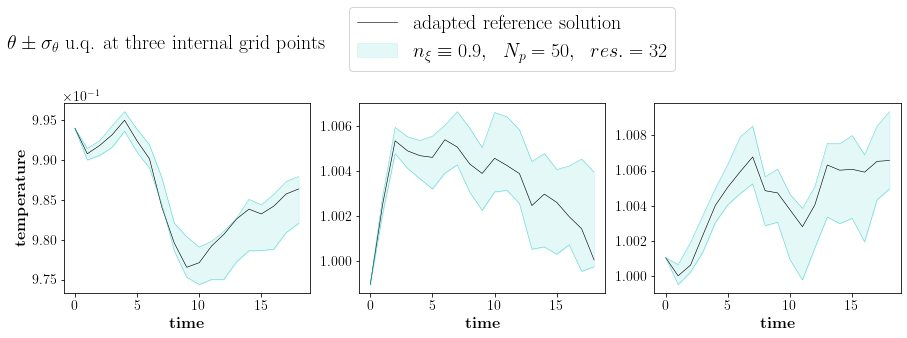

In [24]:
sp = 0 # starting point for plotting results
fig, ax = plt.subplots(1,3, figsize=(15, 3.5))
n = 3 # we are plotting from the 4th gridpoint onwards
spread_col_100p = "blue"
spread_col_50p = "c"
t_col = "red"
for j in [0,1,2]:
    # ax[j].plot(temp_data_d[sp:n_tsteps,n], label = 'deterministic', linewidth=0.6, color="blue")
    ax[j].plot(temp_data_adap[sp:n_tsteps,n], label = 'adapted reference solution', linewidth=0.6, color="black")
    # ax[j].plot(temp_data_t[sp:n_tsteps,n], label = 'c. truth', color=t_col, linewidth=0.6)
    ax[j].plot(temp_std_plus_50p[sp:,n], color=spread_col_50p, linewidth=0.3)
    ax[j].plot(temp_std_minus_50p[sp:,n], color=spread_col_50p, linewidth=0.3)
    ax[j].fill_between(np.arange(n_tsteps -sp),temp_std_plus_50p[sp:,n],temp_std_minus_50p[sp:,n], alpha=.1, color=spread_col_50p, label=r'$n_{\xi}\equiv 0.9, \ \ N_p = 50, \ \ res. = 32$' )
    ax[j].ticklabel_format(axis='y',style='scientific', scilimits=(0,0), useMathText=True)
    n += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.38, 1.3), ncol=1) # positions the legend above the top of the plot without overlapping. 
fig.suptitle(r'$\theta \pm \sigma_{\theta}$ u.q. at three internal grid points', x = 0.22, y = 1.15)
plt.setp(ax[:], xlabel=r'\bf {time}')
plt.setp(ax[0], ylabel=r'\bf {temperature}')
plt.savefig('../plots/gaussian_noise/ensem_temp_mesh_32_90_var_gaussian.pdf',bbox_inches='tight' )

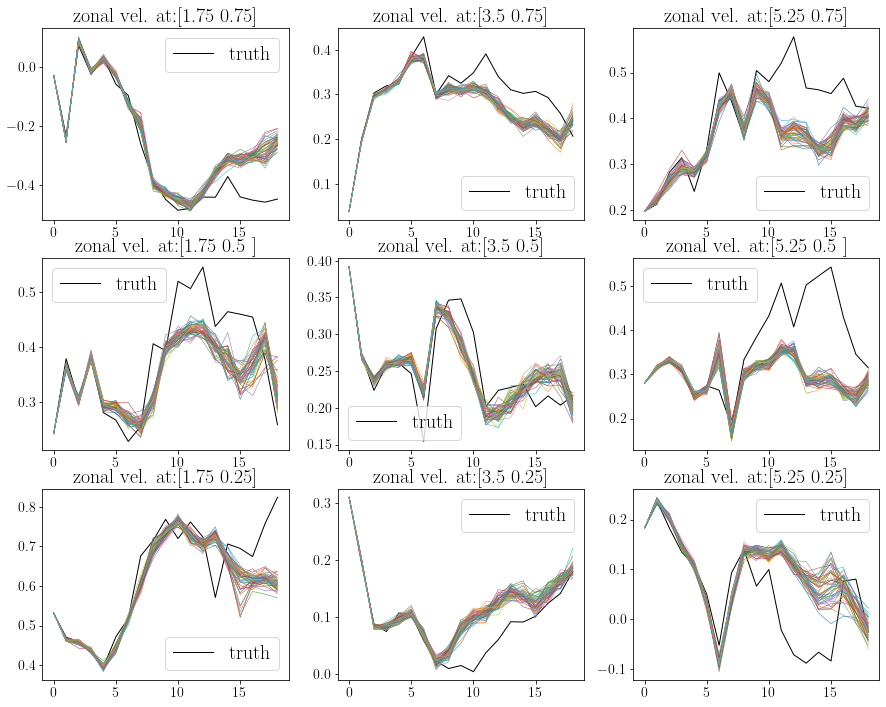

In [26]:
fig, ax = plt.subplots(3,3, figsize=(15, 12))
n = 0
for i in [2,1,0]:
    for j in [0,1,2]:
        ax[i,j].plot(vel_data_t[:n_tsteps,n,0], label = 'truth', linewidth=1, color="black")
        ax[i,j].set_title('zonal vel. at:'+ str(gridpoints[n,:]))
        # print((i,j, n))
        ax[i,j].legend()
        n += 1

for k in range(1, n_stoch_sim_1 + 1):
    data_stoch = np.load('../data_from_stochastic_run/vel_temp_vort_data_particle_'+str(k)+'_var_90_grid_32_t27_onwards_decor_t_32min_upd_noise.npz')
    vel_data_stoch = data_stoch['vel_data_sto']
    n = 0
    for i in [2,1,0]:
        for j in [0,1,2]:
            ax[i,j].plot(vel_data_stoch[:n_tsteps,n,0], linewidth=0.5)
            # ax[i,j].set_title('stochastic sim, x-vel at:'+ str(gridpoints[n,:]))
            # print((i,j, n))
            # ax[i,j].legend()
            n += 1

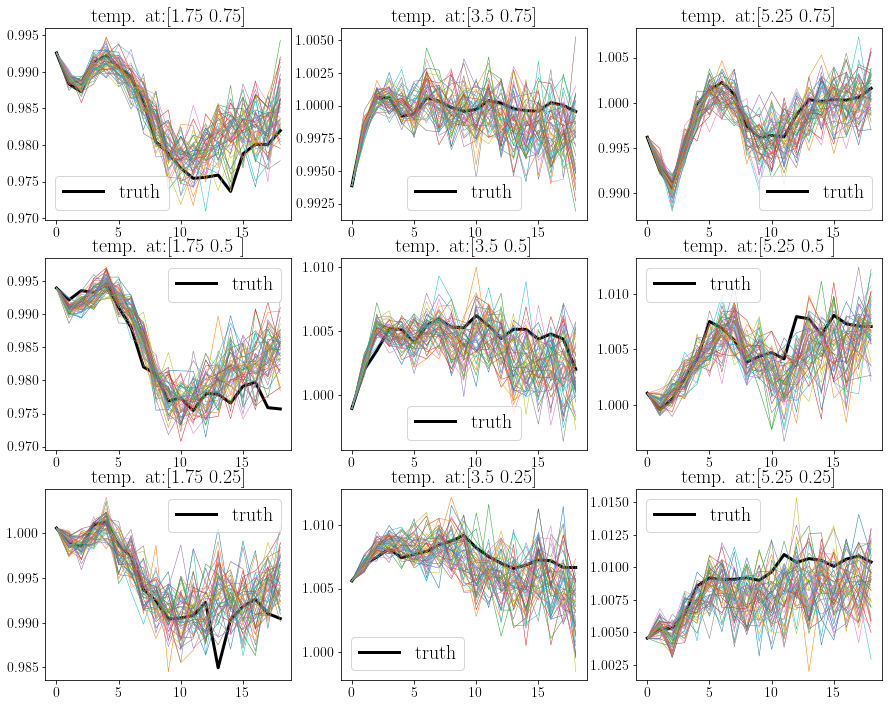

In [27]:
fig, ax = plt.subplots(3,3, figsize=(15, 12))
n = 0
for i in [2,1,0]:
    for j in [0,1,2]:
        ax[i,j].plot(temp_data_t[:n_tsteps,n], label = 'truth', linewidth=3, color="black")
        ax[i,j].set_title('temp. at:'+ str(gridpoints[n,:]))
        # print((i,j, n))
        ax[i,j].legend()
        n += 1

for k in range(1, n_stoch_sim_1 + 1):
    data_stoch = np.load('../data_from_stochastic_run/vel_temp_vort_data_particle_'+str(k)+'_var_90_grid_32_t27_onwards_decor_t_32min_upd_noise.npz')
    temp_data_stoch = data_stoch['temp_data_sto']
    n = 0
    for i in [2,1,0]:
        for j in [0,1,2]:
            ax[i,j].plot(temp_data_stoch[:n_tsteps,n], linewidth=0.5)
            # ax[i,j].set_title('stochastic sim, x-vel at:'+ str(gridpoints[n,:]))
            # print((i,j, n))
            # ax[i,j].legend()
            n += 1